# Electric Motor Temperature

The influencing factors of stator winding temperature and prevent motor insulation ageing, insulation burning, permanent magnet demagnetization and other faults caused by high stator winding temperature, we propose a computer model for PMSM temperature prediction. Ambient temperature, coolant temperature, direct-axis voltage, quadrature-axis voltage, motor speed, torque, direct-axis current, quadrature-axis current, permanent magnet surface temperature, stator yoke temperature, and stator tooth temperature are taken as the input, while the stator winding temperature is taken as the output.

This dataset provides readings from several sensors fitted to monitor the main two pieces of PMSMs, namely the stator and the rotor. Below image showcases the components under consideration.

Generally, due to presence of moving parts working under various states of the motor speed and torque (a point at the motor speed x torque plain) thermal losses will be generated which impact the equipment in the long run shortening its lifespan. The copper loss of a permanent magnet motor stator directly affects the heating degree of the stator winding.

The stator is the stationary component of electromagnetic circuits in motors. In different configurations, stators may act as field magnets that interact with the rotor to create motion, or as armatures that work with moving field coils on the rotor.

<img src="Motor.JPG" alt="Drawing" style="width: 400px;"/>

Below is a simple description of the data from the sensors mentioned above:

**u_q**: q component of Voltage measured in Volts0

**u_d**: d component of Voltage measured in Volts

**i_q**: q component of Current measured in Amps

**i_d**: d component of Current measured in Amps

**ambient**: ambient temperature around the stator in °C (measured by a thermal sensor fixed close to stator)

**coolant**: motor coolant (water in this case) temperature of the motor in °C (measured by a fixed thermal sensor at coolant outlet)

**motor speed**: ambient temperature around the stator in °C (measured by a fixed thermal sensor)

**stator_tooth**: stator tooth temperature in °C

**stator_winding**: stator winding temperature in °C

**stator_yoke**: stator yoke temperature in °C

**pm**: permanent magnet tooth temperature in °C

**profile_id**: id of the measurement session

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.preprocessing import StandardScaler
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

#### Data load

In [2]:
data = pd.read_csv(".\\data\\measures_v2.csv")

In [3]:
data

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,1.871008e-01,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,2.454175e-01,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,1.766153e-01,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,2.383027e-01,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,2.081967e-01,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,-2.152128,30.721298,45.274497,0.791801,41.934347,0.000380,-2.000169,1.097528,62.147780,38.653720,23.989078,-8.116730e-60,71
1330812,-2.258684,30.721306,45.239017,0.778900,41.868923,0.002985,-2.000499,1.097569,62.142646,38.656328,23.970700,-5.815891e-60,71
1330813,-2.130312,30.721312,45.211576,0.804914,41.804819,0.002301,-1.999268,1.098765,62.138387,38.650923,23.977234,-4.167268e-60,71
1330814,-2.268498,30.721316,45.193508,0.763091,41.762220,0.005662,-2.000999,1.095696,62.133422,38.655686,24.001421,-2.985978e-60,71


#### Filtering

In [4]:
data = data.reset_index(drop=True)
data

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,1.871008e-01,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,2.454175e-01,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,1.766153e-01,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,2.383027e-01,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,2.081967e-01,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,-2.152128,30.721298,45.274497,0.791801,41.934347,0.000380,-2.000169,1.097528,62.147780,38.653720,23.989078,-8.116730e-60,71
1330812,-2.258684,30.721306,45.239017,0.778900,41.868923,0.002985,-2.000499,1.097569,62.142646,38.656328,23.970700,-5.815891e-60,71
1330813,-2.130312,30.721312,45.211576,0.804914,41.804819,0.002301,-1.999268,1.098765,62.138387,38.650923,23.977234,-4.167268e-60,71
1330814,-2.268498,30.721316,45.193508,0.763091,41.762220,0.005662,-2.000999,1.095696,62.133422,38.655686,24.001421,-2.985978e-60,71


# Data visualization

In [5]:
data['pm'].mean()

58.50677585061559

<AxesSubplot:xlabel='pm', ylabel='Density'>

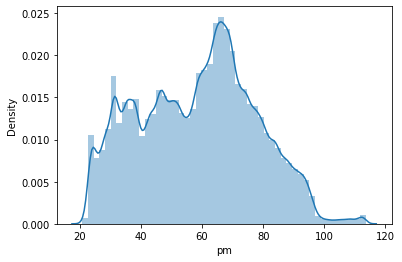

In [6]:
sns.distplot(data['pm'])

For pm features, mean values is 58.

<AxesSubplot:xlabel='stator_yoke', ylabel='Density'>

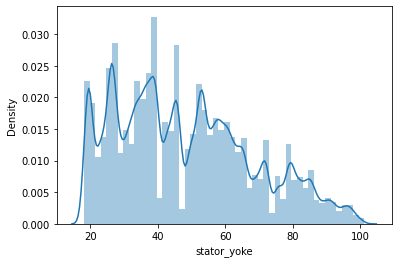

In [7]:
sns.distplot(data['stator_yoke'])

For stator_yoke features, mean values is 48.

In [8]:
data['stator_yoke'].mean()

48.187964864903044

<AxesSubplot:xlabel='stator_tooth', ylabel='Density'>

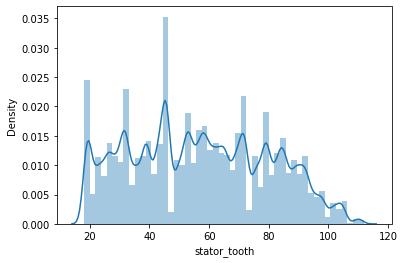

In [9]:
sns.distplot(data['stator_tooth'])

For stator_tooth features, mean values is 56.

<AxesSubplot:xlabel='stator_winding', ylabel='Density'>

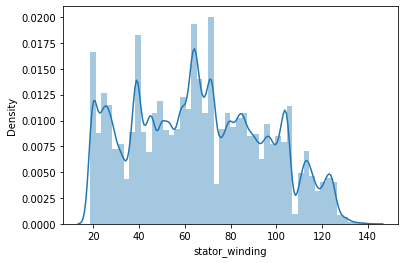

In [10]:
sns.distplot(data['stator_winding'])

For stator winding,mean values is 66.

<AxesSubplot:xlabel='torque', ylabel='Density'>

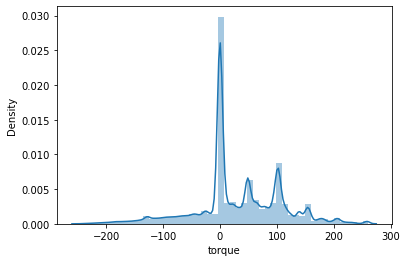

In [11]:
sns.distplot(data['torque'])

For torque, mean values is 31.

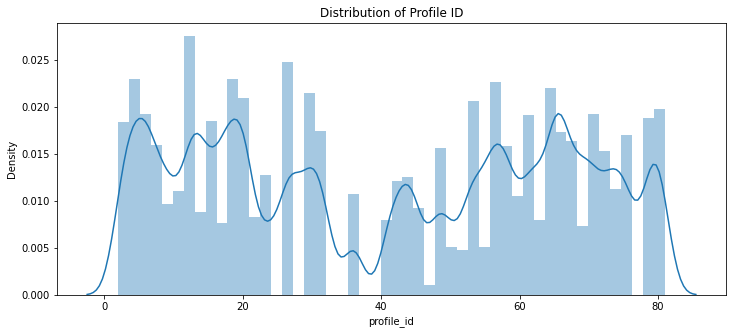

In [12]:
plt.figure(figsize=(12,5))
plt.title("Distribution of Profile ID")
ax = sns.distplot(data['profile_id'])

Distribution of profile ID show us profile id

p-value for Profile ID: 0.0


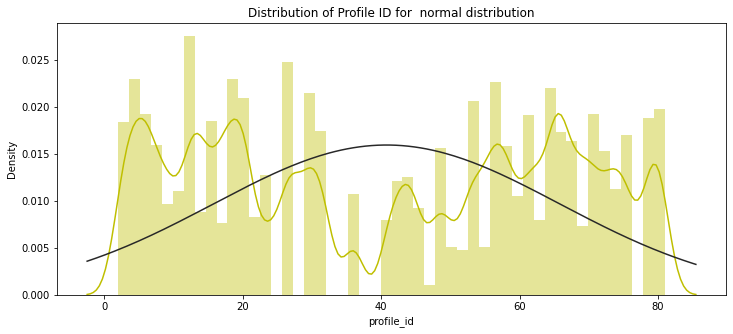

In [13]:
print("p-value for Profile ID: {}".format(st.normaltest(data.profile_id.values)[1]))
plt.figure(figsize=(12,5))
plt.title("Distribution of Profile ID for  normal distribution")
ax = sns.distplot(data.profile_id, fit= st.norm, kde=True, color='y')

The yellow line display Profile ID, while the black line is the best normal distribution we can fit to our data.

Text(0, 0.5, 'Stator winding temperature')

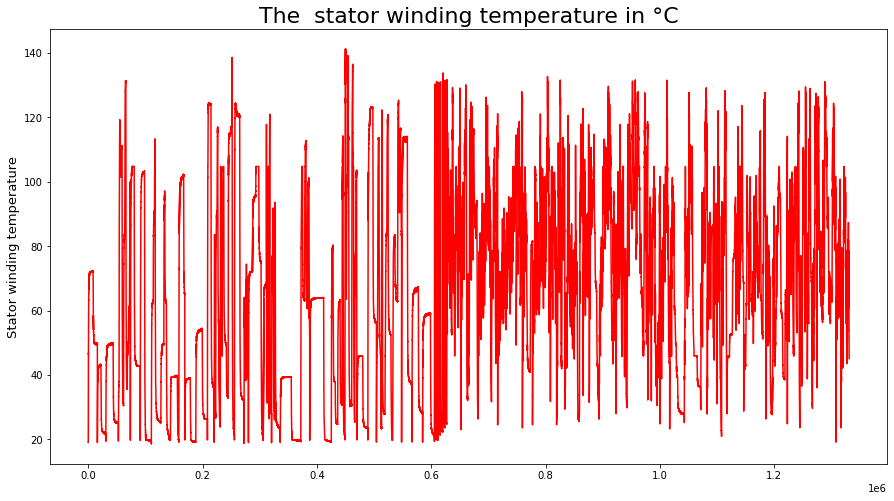

In [14]:
# Plot the winding temperature
plt.figure(figsize = (15, 8))

plt.plot(data['stator_winding'], 'r')

plt.title('The  stator winding temperature in °C', fontsize = 22)
plt.ylabel('Stator winding temperature', fontsize = 13)

The graph shows us max temperature for stator winding is about 141, min is about 18 and mean is about 66.

Text(0, 0.5, 'Stator Yoke temperature')

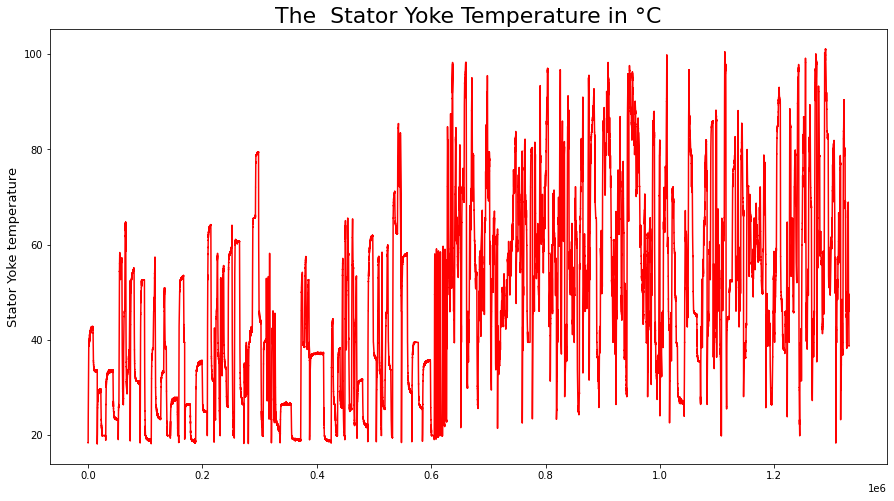

In [15]:
# Plot the stator yoke temperature
plt.figure(figsize = (15, 8))

plt.plot(data['stator_yoke'], 'r')

plt.title('The  Stator Yoke Temperature in °C', fontsize = 22)
plt.ylabel('Stator Yoke temperature', fontsize = 13)

The graph shows us max temperature for stator winding is about 101, min is about 18 and mean is about 48.

Text(0, 0.5, 'Stator Tooth temperature')

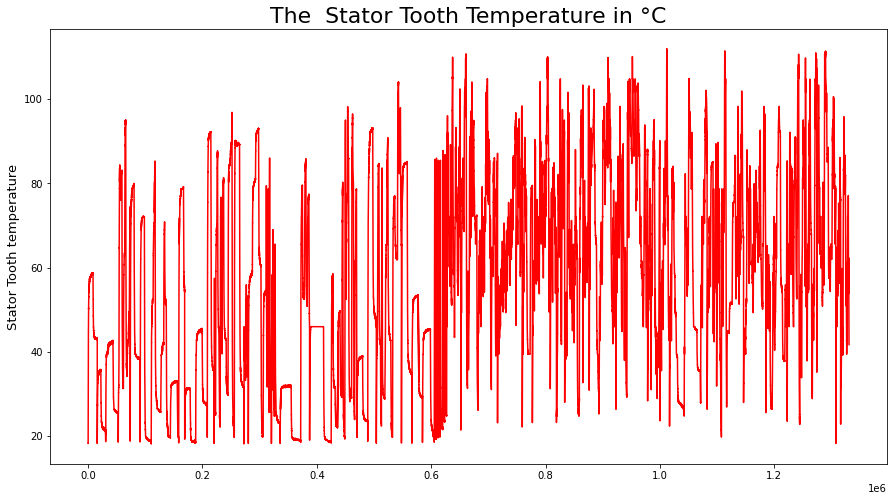

In [16]:
# Plot the stator tooth temperature
plt.figure(figsize = (15, 8))

plt.plot(data['stator_tooth'], 'r')

plt.title('The  Stator Tooth Temperature in °C', fontsize = 22)
plt.ylabel('Stator Tooth temperature', fontsize = 13)

The graph shows us max temperature for stator winding is about 112, min is about 18 and mean is about 56.

<AxesSubplot:>

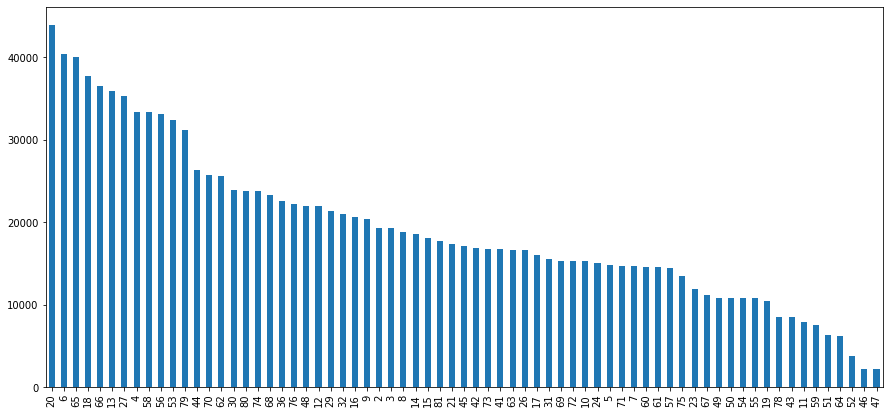

In [17]:
plt.subplots(figsize=(15,7))
data['profile_id'].value_counts().plot(kind = 'bar')

We see that most frequent data for profile id is 20, 6 and 65

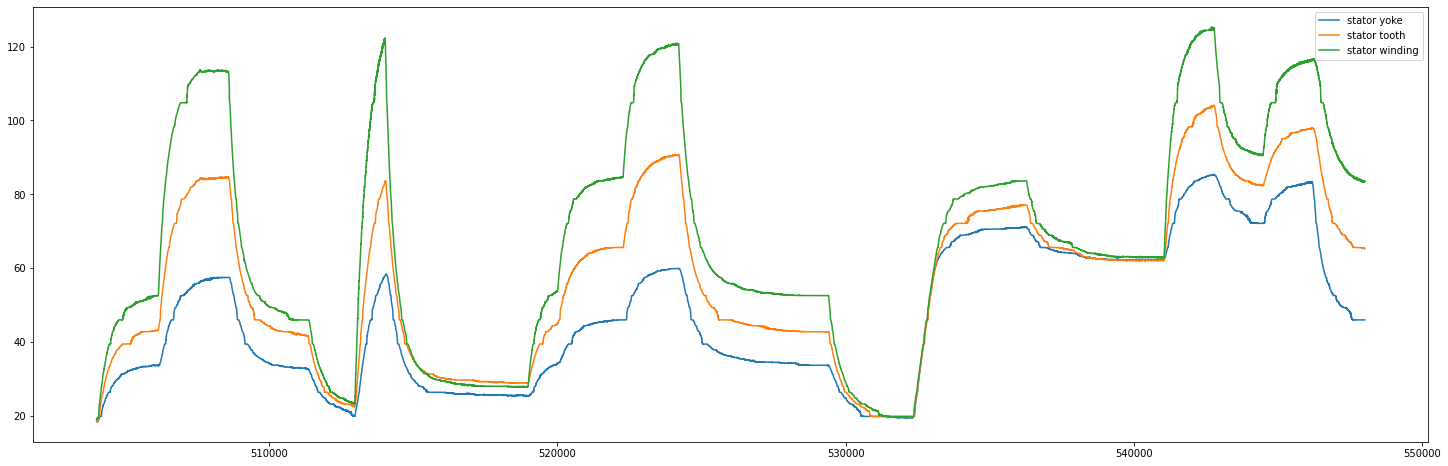

In [18]:
plt.figure(figsize=(25,8))
data[data['profile_id'] == 20]['stator_yoke'].plot(label = 'stator yoke')
data[data['profile_id'] == 20]['stator_tooth'].plot(label = 'stator tooth')
data[data['profile_id'] == 20]['stator_winding'].plot(label = 'stator winding')
plt.legend()

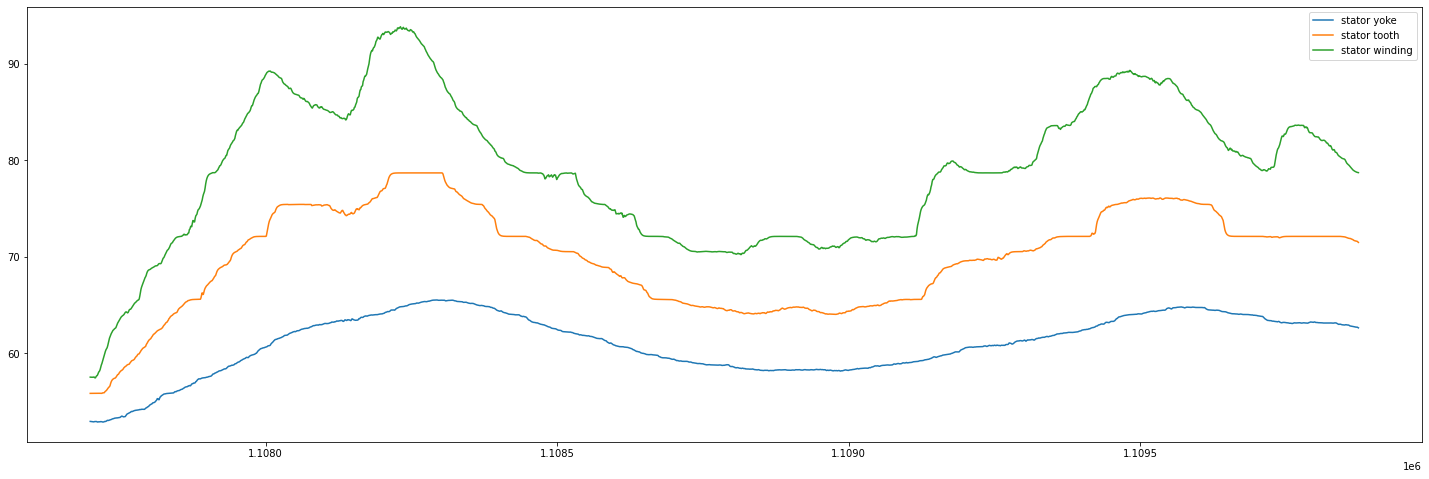

In [19]:
plt.figure(figsize=(25,8))
data[data['profile_id'] == 47]['stator_yoke'].plot(label = 'stator yoke')
data[data['profile_id'] == 47]['stator_tooth'].plot(label = 'stator tooth')
data[data['profile_id'] == 47]['stator_winding'].plot(label = 'stator winding')
plt.legend()

Min and max values for profile id Visualize stator features and differ each-others. Stator yoke has more density than others.

So for minimum profile id has more differ aming stator features.

#### Check data

In [20]:
data.shape

(1330816, 13)

In [21]:
data.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01,4.079306e+01
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01,2.504549e+01
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02,2.000000e+00
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01,1.700000e+01
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01,4.300000e+01
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01,6.500000e+01
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02,8.100000e+01


In [22]:
data.dtypes

u_q               float64
coolant           float64
stator_winding    float64
u_d               float64
stator_tooth      float64
motor_speed       float64
i_d               float64
i_q               float64
pm                float64
stator_yoke       float64
ambient           float64
torque            float64
profile_id          int64
dtype: object

In [23]:
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    first_memory = df.memory_usage().sum() / 1024**2
    print('First memory usage of dataframe is {:.2f} MB'.format(first_memory))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    second_memory = df.memory_usage().sum() / 1024**2
    print('Second memory usage : {:.2f} MB'.format(second_memory))
    print('Decreased by {:.1f}%'.format(100 * (first_memory - second_memory) / first_memory))
    
    

reduce_memory(data)

First memory usage of dataframe is 131.99 MB
Second memory usage : 31.73 MB
Decreased by 76.0%


In [24]:
# Dataset size after decrease.
data.dtypes

u_q               float16
coolant           float16
stator_winding    float16
u_d               float16
stator_tooth      float16
motor_speed       float16
i_d               float16
i_q               float16
pm                float16
stator_yoke       float16
ambient           float16
torque            float16
profile_id           int8
dtype: object

In [25]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float16
 1   coolant         1330816 non-null  float16
 2   stator_winding  1330816 non-null  float16
 3   u_d             1330816 non-null  float16
 4   stator_tooth    1330816 non-null  float16
 5   motor_speed     1330816 non-null  float16
 6   i_d             1330816 non-null  float16
 7   i_q             1330816 non-null  float16
 8   pm              1330816 non-null  float16
 9   stator_yoke     1330816 non-null  float16
 10  ambient         1330816 non-null  float16
 11  torque          1330816 non-null  float16
 12  profile_id      1330816 non-null  int8   
dtypes: float16(12), int8(1)
memory usage: 31.7 MB


In [26]:
# Null values
data.isna().sum().sum()

0

In [27]:
data.isna().sum()

u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
profile_id        0
dtype: int64

Our dataset has no null values

In [28]:
print(data.duplicated().sum())

1960


Our dataset has 1960 duplcate rows.

### Correlation

In [29]:
# Correlation between features for train
train_corr  = data.corr(method='pearson').abs()
train_corr.style.background_gradient(cmap='Wistia').set_precision(2)

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
u_q,1.00,0.05,0.05,0.00,0.10,0.68,0.10,0.12,0.12,0.09,0.15,0.14,0.03
coolant,0.05,1.00,0.50,0.20,0.67,0.01,0.07,0.26,0.47,0.86,0.53,0.26,0.64
stator_winding,0.05,0.50,1.00,0.23,0.97,0.43,0.62,0.07,0.80,0.86,0.33,0.10,0.34
u_d,0.00,0.20,0.23,1.00,0.14,0.29,0.45,0.72,0.17,0.01,0.20,0.75,0.26
stator_tooth,0.10,0.67,0.97,0.14,1.00,0.40,0.49,0.04,0.83,0.95,0.44,0.02,0.45
motor_speed,0.68,0.01,0.43,0.29,0.40,1.00,0.70,0.07,0.46,0.26,0.12,0.04,0.03
i_d,0.10,0.07,0.62,0.45,0.49,0.70,1.00,0.23,0.43,0.28,0.02,0.27,0.05
i_q,0.12,0.26,0.07,0.72,0.04,0.07,0.23,1.00,0.14,0.13,0.31,1.00,0.32
pm,0.12,0.47,0.80,0.17,0.83,0.46,0.43,0.14,1.00,0.76,0.51,0.12,0.39
stator_yoke,0.09,0.86,0.86,0.01,0.95,0.26,0.28,0.13,0.76,1.00,0.52,0.12,0.56


In [30]:
# drop out highly correlated features for train
upper_tri = train_corr.where(np.triu(np.ones(train_corr.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
to_drop1 = [column for column in upper_tri.columns if any(upper_tri[column] < -0.5)]
print('More than 0.85 is: ', to_drop, '\n less than -0.5 is: ', to_drop1)
#traindrop = data.drop(to_drop, axis=1)
# train_corrs  = traindrop.corr(method='pearson').style.background_gradient(cmap='Wistia').set_precision(2)
# train_corrs

More than 0.85 is:  ['stator_tooth', 'stator_yoke', 'torque'] 
 less than -0.5 is:  []


While stator_tooth, stator_yoke and torque have highly coorelations, these features are targets of our dataset.

In [31]:
#data.drop('profile_id',axis=1,inplace=True)

In [32]:
X = data.drop(['pm', 'stator_yoke', 'stator_tooth', 'stator_winding', 'torque'],axis=1)
X.shape

(1330816, 8)

In [33]:
y = data[['pm', 'stator_yoke', 'stator_tooth', 'stator_winding', 'torque']]
y.shape

(1330816, 5)

So our dataset has multiple targets (stator_tooth, stator_yoke, stator_winding, pm and torque)

# Train Test Split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, shuffle=True)

In [35]:
cols = X_train.columns

### Feature Scaling - StandardScaler

In [36]:
#Scaling the features
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

# fit and transform
X_trains = sc_X.fit_transform(X_train)
X_tests = sc_X.transform(X_test)

In [37]:
# Scaling dataframe
X_Train = pd.DataFrame(X_trains, columns=[cols])

X_Test = pd.DataFrame(X_tests, columns=[cols])

In [38]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1064652, 8), (1064652, 5), (266164, 8), (266164, 5))

## Mean Absolute Error

### LinearRegression

In [39]:
LR = LinearRegression()

# fit model
LR.fit(X_train, y_train)

# make class predictions for the testing set
y_pred_class = LR.predict(X_test)

print(metrics.mean_absolute_error(y_test, y_pred_class))

7.569275


In [40]:
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
LR_kfold = LinearRegression()

scoring = 'neg_mean_absolute_error'
results = cross_val_score(LR_kfold, X_train, y_train, cv=kfold, scoring=scoring)

print("MAE: %.3f, Standard Deviation: (%.3f)" % (results.mean(), results.std()))

MAE: -7.568, Standard Deviation: (0.022)


   ###    Decision Tree

In [41]:
DT = DecisionTreeRegressor(random_state=0)

DT.fit(X_train,y_train)
predTree = DT.predict(X_test)

DT_MAE =  metrics.mean_absolute_error(y_test, predTree)
DT_MAE

0.7406244547923696

### KNN

In [42]:
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train,y_train)

pred_neigh = neigh.predict(X_test)

neigh_MAE =  metrics.mean_absolute_error(y_test, pred_neigh)
neigh_MAE

2.268

## R2 square

### LinearRegression

In [43]:
LR = LinearRegression()

# fit model
LR.fit(X_train, y_train)

# make class predictions for the testing set
y_pred_class = LR.predict(X_test)
LR_r2 = metrics.r2_score(y_test, y_pred_class)
print(metrics.r2_score(y_test, y_pred_class))

0.7880214431934547


### KNN

In [44]:
neigh_R2 =  metrics.r2_score(y_test, pred_neigh)
neigh_R2

0.9503824807888975

In [45]:
lin_reg = LinearRegression(n_jobs = -1)
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
r2_lin_reg = metrics.r2_score(y_test, y_pred)
print("The R Square for Linear Regression is:", round(r2_lin_reg,3))


The R Square for Linear Regression is: 0.788


In [46]:
ridge = Ridge()
param_grid = {'alpha': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100]}
grid_search_ridge = RandomizedSearchCV(ridge, param_grid, cv = 5)
grid_search_ridge.fit(X_train, y_train)
y_pred = grid_search_ridge.predict(X_test)
r2_ridge_reg = metrics.r2_score(y_test, y_pred)
print("The R Square  Error for Ridge Regression is:", round(r2_ridge_reg,3))


The R Square  Error for Ridge Regression is: 0.788


In [47]:
lasso = Lasso()
param_grid = {'alpha': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100]}
grid_search_las = RandomizedSearchCV(lasso, param_grid, cv = 3)
grid_search_las.fit(X_train, y_train)
y_pred = grid_search_las.predict(X_test)
r2_las_reg = metrics.r2_score(y_test, y_pred)
print("The Root Mean Squared Error for Lasso Regression is:", round(r2_las_reg,3))


The Root Mean Squared Error for Lasso Regression is: 0.788


In [48]:
el_net = ElasticNet()
param_grid = {'alpha': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100],
             'l1_ratio': np.arange(0.0, 1.0, 0.1)}
grid_search_el_net = RandomizedSearchCV(el_net, param_grid, cv = 3)
grid_search_el_net.fit(X_train, y_train)
y_pred = grid_search_el_net.predict(X_test)
r2_el_net = metrics.r2_score(y_test, y_pred)
print("The Root Mean Squared Error for Elastic Net is:", round(r2_el_net,3))


The Root Mean Squared Error for Elastic Net is: 0.788


In [49]:
dtr = DecisionTreeRegressor(random_state = 0)
param_grid = {'max_depth': list(range(2, 10)),
              'splitter': ['best', 'random'],
              'min_samples_leaf': list(range(1, 10)),
              'max_leaf_nodes': list(range(5, 20))}
Rand_search_dtr = RandomizedSearchCV(dtr, param_grid, cv = 5)
Rand_search_dtr.fit(X_train, y_train)
y_pred = Rand_search_dtr.predict(X_test)
r2_dtr = metrics.r2_score(y_test, y_pred)
print("The Root Mean Squared Error for Decision Tree Regressor is:", round(r2_dtr,3))


The Root Mean Squared Error for Decision Tree Regressor is: 0.703


## Compare models

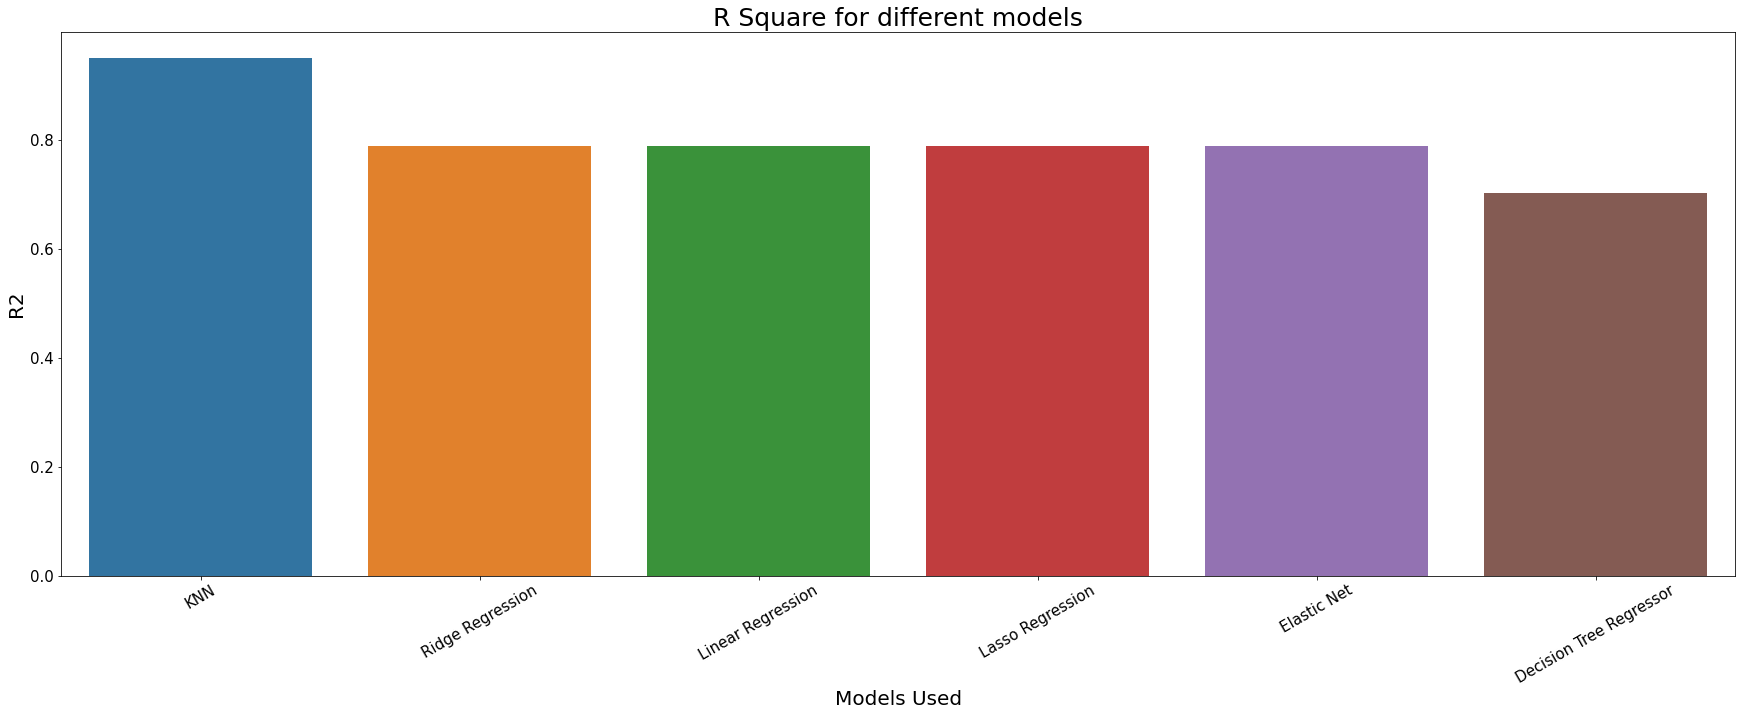

In [50]:
data = {'Linear Regression': r2_lin_reg, 'Ridge Regression': r2_ridge_reg, 'Lasso Regression': r2_las_reg, 
        'Elastic Net': r2_el_net, 'Decision Tree Regressor': r2_dtr, 'KNN': neigh_R2 }
data = dict(sorted(data.items(), key = lambda x: x[1], reverse = True))
models = list(data.keys())
R2 = list(data.values())
fig = plt.figure(figsize = (30, 10))
sns.barplot(x = models, y = R2)
plt.xlabel("Models Used", size = 20)
plt.xticks(rotation = 30, size = 15)
plt.ylabel("R2", size = 20)
plt.yticks(size = 15)
plt.title("R Square for different models", size = 25)
plt.show()

## Hyperparaemtr with KNN

In [51]:
# Try KNN hyperparametrs
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [52]:
gs = RandomizedSearchCV(KNeighborsRegressor(), grid_params, verbose = 1, cv=3, n_jobs = 6)

# fit the model on our train set
g_res = gs.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [53]:
# get the hyperparameters with the best score
g_res.best_params_

{'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan'}

In [54]:
KNN_hyper = KNeighborsRegressor(n_neighbors = 13, weights = 'distance',
                                        metric = 'manhattan')
KNN_hyper.fit(X_train, y_train)

#Predicting 
y_pred = KNN_hyper.predict(X_test)

# calculating accuracy score
KNN_hyper_R2 =  metrics.r2_score(y_test, y_pred)
KNN_hyper_R2

0.9619685357095717

In this study, l have tryed different models for predict permanent magnet synchronous motor (PMSM). 
As we see KNN models have high accuracy with **95%**. 

That is why use hyperparametr over KNN and get **96%**.
